## Part B: Multi-layer perceptron for diabetes classification

In this section you will learn how to implement a simple neural network in tensorflow and use it to classify whether a patient has diabetes or not based on a number of predictors such as BMI, Insulin levels, etc. 

### Neural networks biological motivation

Not surprisingly there is an analogy between real biological neurons and the neurons used in deep learning. 

Biological Neuron | Computational Neuron
- | - 
<img src="../images/neuron.png" style="height:180px" /> | <img src="../images/neuron_model.jpeg" style="height:180px" />

In both cases a number of inputs get aggregated in a "cell body". In the biological neuron the output axon fires if the input signals cross a certain threshold. Similarly, the output of computational neurons is modulated by the activation function. Most commonly used activation functions go to 0 below a threshold commonly called the bias $b$ and have values greater than 0 above that threshold. 

For the activation function sometimes a [**sigmoid**](https://en.wikipedia.org/wiki/Sigmoid_function) function is used. As we will see in part D of the tutorial, these days more commonly the [**rectified linear unit (ReLU)**](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) is used. However, in this part of the tutorial we will exclusively use the sigmoid activation denoted by $\sigma(\cdot)$. 

<img src="../images/activation_functions.png" style="width: 700px;"/> 

It is important to know that the analogies between computational neural networks and brains are a bit fanciful. In reality we don't really know how brains work. Deep computational neural networks are very crude approximations of biology and it is impossible to gain actual insights into how brains work from them. 

Let us start by loading the necessary packages and setting up the GPU environment. 

In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import math

# This is necessary to load modules form the lib folder of the project
module_path = os.path.abspath(os.path.join('..', 'lib'))
if module_path not in sys.path:
    sys.path.append(module_path)

# os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(os.environ["SGE_GPU"].split('\n'))
# print('SGE_GPU is %s' % os.environ['SGE_GPU'])
# print('CUDA_VISIBLE_DEVICES is %s' % os.environ['CUDA_VISIBLE_DEVICES'])

SGE_GPU is 3
CUDA_VISIBLE_DEVICES is 3


The dataset we will be working with is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage. 

We prepared the data as a python module which you can simply import:

In [2]:
import diabetes_data as data

In a next step, let us visualise a histogram of the 8 different input features and the diabetes of the data. 

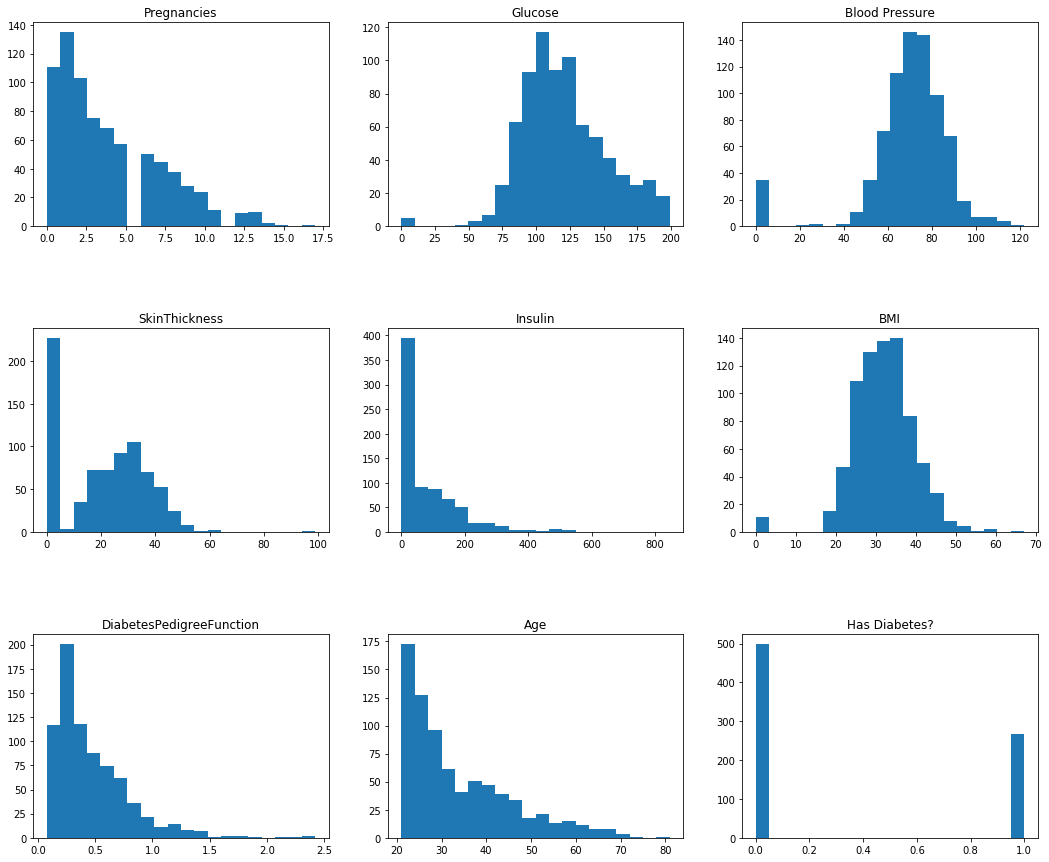

In [3]:
table = np.concatenate([data.X_raw, data.y_raw[:, None]], axis=-1)

feature_names = ('Pregnancies', 'Glucose', 'Blood Pressure',
                 'SkinThickness', 'Insulin', 'BMI',
                'DiabetesPedigreeFunction', 'Age', 'Has Diabetes?')
plt.subplots(figsize=(18,15))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,i*3+j + 1)
        plt.subplots_adjust(wspace=0.2,hspace=0.5)
        plt.hist(table[:, i*3+j], bins=20)
        plt.title(feature_names[i*3+j])
        
plt.show()

Furthermore, let's investigate how large the dataset is:

In [4]:
print('The dataset has %d patients' % table.shape[0])

The dataset has 768 patients


Actually, this is not a big dataset as far as machine learning problems go, but it will serve as a good introduction example. We will see a much bigger dataset in part D of this tutorial. 

Next, let us look at the theory of simple neural networks starting with the simplest of them all. 

### Logistic regression: the simplest neural network

The image below shows the schematic of a single neuron with inputs $x_i$, weights $w_i$ and a bias term $b$. 

For a classification problem with two classes (i.e. a binary classification) the output of a single neuron can be written in matrix form as 

$$ h(x) = \sigma(w^Tx + b), $$ 

where $w = (w_1, w_2, ..., w_D)^T$, $x = (x_1, x_2, ..., x_D)^T$ and $\sigma(z) = 1 / (1 + e^{-z})$ the sigmoid activation function.

This is the widely used **logistic regression classifier** that you saw in the Machine Learning I tutorial yesterday. The output $y \in (0,1)$ can be interpreted as the probability of the inputs $x$ corresponding to class 1 (rather than class 0). 

We can easily build this model in tensorflow. Knowing that our input data has 8 features $x_1, ..., x_8$, and one output, what should the shapes of the vectors $w$ and $b$ be?

In [5]:
X_pl = tf.placeholder(dtype=tf.float32, shape=[None, 8], name='X') # Note that a shape dimension of None means 
y_pl = tf.placeholder(dtype=tf.float32, shape=[None, ], name='y')  # that we can give any size to this placeholder later

# The weights need to be something x 1 matrices, not vectors because we use the tf.matmul matrix multiplication function. 
shape_of_w = (8,1)  # <-- Implement this
shape_of_b = (1,1)  # <-- Implement this

w = tf.Variable(tf.truncated_normal(shape_of_w, stddev=math.sqrt(2.0 / float(8)))) # We initialise the weights randomly
                                                                                   # with a normal distribution
b = tf.Variable(tf.zeros(shape_of_b))
l_out = tf.matmul(X_pl, w) + b
y_out = tf.sigmoid(l_out)

hard_pred_out = tf.round(y_out)  # Rounding the output probability gives a hard 0 prediction if y_out<0.5 
                                 # and a 1 prediction if y_out >= 0.5

Note that we initialised the weights $w$ with a random distribution with a specific standard deviation (stddev). There are some rules for choosing a good standard deviation to facilitate the learning, we will see a strategy called Xavier initialisation further down. However, for this simple problem almost any distribution should work. 

### Training a logistic regression classifier 

The weights $w$ and the bias $b$ are the **parameters** of the model. Given a training set of inputs $x^{(n)}$ and ground truth labels $y^{(n)}$ the objective is to find values for $w$ and $b$ that map the network output $h(x^{(n)})$ for each input $x^{(n)}$ to the correct $y^{(n)}$ as well as possible. Let us collectively refer to all parameters as $\phi = (w,b)$ to simplify notation. This is usually done by minimising the **cross entropy loss** which is defined as:

$$ J(\phi) = -\sum_{n=1}^N y^{(n)} \log\left(h(x^{(n)})\right) + (1-y^{(n)})\log\left(1-h(x^{(n)})\right) $$

This loss comes from signal processing. To understand it intuitively you can think about what happens if the ground-truth label is $y^{(n)}=0$ and what happens if it is $y^{(n)}=1$ and what values the log function can take. However, going into the details of this loss beyond the scope of this tutorial. It is enough to know that the values of $w,b$ that produce the smallest value of $J$ will lead to a in some sense optimal classification.  

Note that the sum above goes over all training pairs $\{x^{(n)}, y^{(n)} \}$. However, often when working with huge datasets we cannot load the entire dataset at once because of memory restrictions. Instead the data is randomly split into smaller **mini batches**. For each mini batch a simple gradient descent step is performed to move the parameters $\phi$ in the direction of decreasing loss: 

$$ \phi_{t+1} = \phi_t - \lambda \frac{\partial}{\partial \phi_t} J(\phi_t) $$ 

This procedure is referred to as **mini batch gradient descent**.

`tensorflow` provides handy functions to implement all of this. Specifically, we almost always use the `tf.nn.sigmoid_cross_entropy_with_logits` function to implement the loss. This function expects the ground-truth labels (`y_pl`, in our case) and the output **logits**, i.e. the thing *before* the sigmoid function for computational reasons. When we defined the model above we defined it as `l_out`. 

We can also define an **optimiser** using `tensorflow`. Below, we chose the `tf.train.AdamOptimizer` with a learning rate of $\lambda=0.005$. Adam is a very powerful mini batch gradient descent optimizer that tends to produce good results without much tuning. 

In [6]:
# Define the loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.expand_dims(y_pl, axis=-1), logits=l_out) 
                # The `tf.expand_dims` function above is needed to 
                # make the dimensions of the two tensorflow objects match. 
        
# Define the optimiser and a training operation that performs a single mini batch gradient descent step
optimiser = tf.train.AdamOptimizer(learning_rate=0.005)  
train_op = optimiser.minimize(loss)

# Define the initialisation operation that, when run in the session, will assign the initial values to w and b
init = tf.global_variables_initializer()

Let us also define two helper functions to validate the model performance during training and to evaluate the final performance of the classifier after training.

In [7]:
def validate(sess, data_fold, loss_pl, X_pl, y_pl):
    
    total_loss = 0
    total_points = 0
    for val_batch in data_fold.iterate_batches(1):
        X_b, y_b = val_batch
        total_loss += sess.run(loss_pl, feed_dict={X_pl: X_b, y_pl: y_b})[0]
        total_points += 1
        
    return total_loss / total_points

from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
def evaluate_test_set(sess, X_pl, hard_pred_out):

    predictions_eval = sess.run(hard_pred_out, feed_dict={X_pl: data.X_test})

    print('Classification Report:')
    print(classification_report(data.y_test, predictions_eval, target_names=['Diabetes', 'No Diabetes']))

    print('Confusion Matrix:')
    print(confusion_matrix(data.y_test, predictions_eval, labels=[0,1]))

    print('Accuracy: %.2f percent' % (accuracy_score(data.y_test, predictions_eval)*100))

To simplify the mini batch learning the datasets we use in this tutorial already have functions built-in to slice up the data into mini batches of a desired size. The example below, slices the training data into batches of size 10 and iterates through the whole dataset once (ignoring the last batch that will no longer have 10 elements). 

In [8]:
counter = 0
for batch in data.train.iterate_batches(batch_size=10):
    Xb, yb = batch
    print('Shape of batch #%d:' % counter)
    print(Xb.shape)
    print(yb.shape)
    counter += 1

Shape of batch #0:
(10, 8)
(10,)
Shape of batch #1:
(10, 8)
(10,)
Shape of batch #2:
(10, 8)
(10,)
Shape of batch #3:
(10, 8)
(10,)
Shape of batch #4:
(10, 8)
(10,)
Shape of batch #5:
(10, 8)
(10,)
Shape of batch #6:
(10, 8)
(10,)
Shape of batch #7:
(10, 8)
(10,)
Shape of batch #8:
(10, 8)
(10,)
Shape of batch #9:
(10, 8)
(10,)
Shape of batch #10:
(10, 8)
(10,)
Shape of batch #11:
(10, 8)
(10,)
Shape of batch #12:
(10, 8)
(10,)
Shape of batch #13:
(10, 8)
(10,)
Shape of batch #14:
(10, 8)
(10,)
Shape of batch #15:
(10, 8)
(10,)
Shape of batch #16:
(10, 8)
(10,)
Shape of batch #17:
(10, 8)
(10,)
Shape of batch #18:
(10, 8)
(10,)
Shape of batch #19:
(10, 8)
(10,)
Shape of batch #20:
(10, 8)
(10,)
Shape of batch #21:
(10, 8)
(10,)
Shape of batch #22:
(10, 8)
(10,)
Shape of batch #23:
(10, 8)
(10,)
Shape of batch #24:
(10, 8)
(10,)
Shape of batch #25:
(10, 8)
(10,)
Shape of batch #26:
(10, 8)
(10,)
Shape of batch #27:
(10, 8)
(10,)
Shape of batch #28:
(10, 8)
(10,)
Shape of batch #29:
(10,

The following loop executes the `train_op` we defined above multiple times for different mini batches. The inner loop goes over the dataset once as in the example above. Hence the outer loop repeats this 50 times. One whole pass over the training data is often called an **epoch**. This means we train the model for 50 epochs. In the code below, execute the training operation defined above in the tf.Session(). 

Step: 0 (epoch 0)
 - Validation Loss: 0.783835
 - Training Loss: 0.773036
Step: 500 (epoch 10)
 - Validation Loss: 0.522079
 - Training Loss: 0.485043
Step: 1000 (epoch 20)
 - Validation Loss: 0.514020
 - Training Loss: 0.476043
Step: 1500 (epoch 30)
 - Validation Loss: 0.508494
 - Training Loss: 0.475684
Step: 2000 (epoch 40)
 - Validation Loss: 0.516027
 - Training Loss: 0.475091


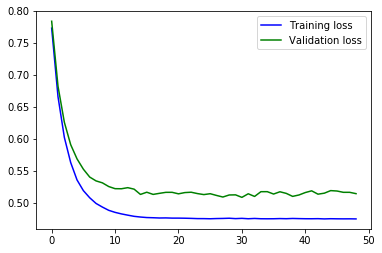

In [9]:
step = 0
train_losses = []
val_losses = []

sess = tf.Session()
sess.run(init)
    
for epoch in range(50):  

    for batch in data.train.iterate_batches(10):

        X_b, y_b = batch
        
        sess.run(train_op, feed_dict={X_pl: X_b, y_pl: y_b})  # Implement this

        if step % 50 == 0: 
            
            val_loss = validate(sess, data.validation, loss, X_pl, y_pl)
            train_loss = validate(sess, data.train, loss, X_pl, y_pl)
            
            val_losses.append(val_loss)
            train_losses.append(train_loss)

        if step % 500 == 0:

            print('Step: %d (epoch %d)' % (step, epoch))
            print(' - Validation Loss: %f' % val_loss)
            print(' - Training Loss: %f' % train_loss)

        step += 1
      
plt.plot(range(len(train_losses)), train_losses, 'b-',
         range(len(val_losses)), val_losses, 'g-')
plt.legend(['Training loss','Validation loss'])
plt.show()

Next, we can evaluate the performance of this classifier using the function we defined above. Precision and recall measure the systems ability to correctly classify diabetes cases, and the percentage of correctly retrieved diabetes cases, respectively. The f1 score is an average between the two. 

In [10]:
evaluate_test_set(sess, X_pl, hard_pred_out)

Classification Report:
             precision    recall  f1-score   support

   Diabetes       0.76      0.82      0.79       100
No Diabetes       0.61      0.52      0.56        54

avg / total       0.71      0.71      0.71       154

Confusion Matrix:
[[82 18]
 [26 28]]
Accuracy: 71.43 percent


Note that something very similar is happening "under the hood" if you run the `sklearn` logistic regression classifier. However, to build state-of-the-art deep learning architectures the additional flexibility gained by implementing this ourselves using `tensorflow` is very useful. Let us now build a more complicated network using the same approach.

### Multi-layer perceptrons. 

The basic neuron unit from above can be arranged in layers to form a multi-layer neural network:

<img src="../images/mlp.png" style="height:230px"/>

The example above shows a network with 2 input features, 2 hidden layers with 4 and 3 neurons, respectively, and one output. In the last layer we almost always use a sigmoid function for binary classification, in the intermediate layers other activation functions such as the ReLU can be used, however, here we will also use the sigmoid. Note that the last layer is, in fact, exactly a logistic regression classifier with 3 inputs. 

Each of the arrows has a weight value attached to it. Let's focus only on the first layer for now. Since every unit of the input is connected with every unit of the first hidden layer the weights can be expressed as a 2D matrix. The activation of the each neuron is calculated described in the last section. This can be conveniently calculated by a matrix multiplication. 

$a^{(1)} = \sigma(W^{(1)}x + b^{(1)}) \quad
\mbox{with}
\quad   
W^{(1)} = \begin{bmatrix} 
 w_{11} & w_{12} & w_{13} & w_{14} \\
 w_{21} & w_{22} & w_{23} & w_{24}
\end{bmatrix} \quad \mbox{and} \quad b^{(1)} = \begin{bmatrix} 
 b_1 \\
 b_2 
 \end{bmatrix} $
 
The activation $a^{(1)}$ then serves as the input to the next layer and so on. 

Using the template below extend the logistic regression classifier model from above to a 2 hidden layer neural network with 10 neurons in the first layer, and 5 neurons in the second hidden layer. Use the following formula to set the standard deviation of the initial distribution of each weight matrix:

$$ stddev_W = \sqrt{\frac{2}{(\#\,inputs) + (\#\,outpus)}} $$

Initialising weights with a normal distribution with this standard deviation is called **Xavier initialisation**. 


In [11]:
X_pl = tf.placeholder(tf.float32, [None, 8], name='X')
y_pl = tf.placeholder(tf.float32, [None, ], name='y')

input_size = 8
num_hidden_1 = 10
num_hidden_2 = 5
output_size = 1 

##################

W1 = tf.Variable(tf.truncated_normal([input_size, num_hidden_1], stddev=math.sqrt(2.0 / float(input_size + num_hidden_1))))  
b1 = tf.Variable(tf.zeros([num_hidden_1])) 
a1 = tf.nn.sigmoid(tf.matmul(X_pl, W1) + b1)

W2 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], stddev=math.sqrt(2.0 / float(num_hidden_1 + num_hidden_2))))
b2 = tf.Variable(tf.zeros([num_hidden_2])) 
a2 = tf.nn.sigmoid(tf.matmul(a1, W2) + b2)

W3 = tf.Variable(tf.truncated_normal([num_hidden_2, output_size], stddev=math.sqrt(2.0 / float(num_hidden_2 + output_size))))                             
b3 = tf.Variable(tf.zeros([output_size])) 

l_out = tf.matmul(a2, W3) + b3

##################

y_out = tf.sigmoid(l_out)
hard_pred_out = tf.round(y_out)

The loss and optimisation are exactly the same as in the logistic regression example:

In [12]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.expand_dims(y_pl, axis=-1), logits=l_out)
optimiser = tf.train.AdamOptimizer(0.005)
train_op = optimiser.minimize(loss)
init = tf.global_variables_initializer()

Also the training loop is exactly the same as before. Go ahead and run the training. 

Step: 0 (epoch 0)
 - Validation Loss: 0.755811
 - Training Loss: 0.761056
Step: 500 (epoch 10)
 - Validation Loss: 0.519626
 - Training Loss: 0.476472
Step: 1000 (epoch 20)
 - Validation Loss: 0.516230
 - Training Loss: 0.464226
Step: 1500 (epoch 30)
 - Validation Loss: 0.508903
 - Training Loss: 0.453584
Step: 2000 (epoch 40)
 - Validation Loss: 0.501402
 - Training Loss: 0.445500


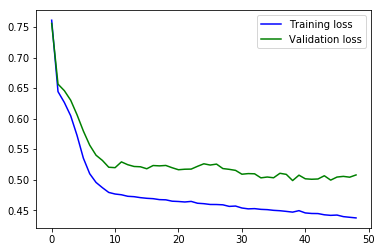

In [13]:
step = 0
train_losses = []
val_losses = []

sess = tf.Session()
sess.run(init)
    
for epoch in range(50): 

    for batch in data.train.iterate_batches(10):

        X_b, y_b = batch
        
        sess.run(train_op, feed_dict={X_pl: X_b, y_pl: y_b})

        if step % 50 == 0: 
            
            val_loss = validate(sess, data.validation, loss, X_pl, y_pl)
            train_loss = validate(sess, data.train, loss, X_pl, y_pl)
            
            val_losses.append(val_loss)
            train_losses.append(train_loss)

        if step % 500 == 0:

            print('Step: %d (epoch %d)' % (step, epoch))
            print(' - Validation Loss: %f' % val_loss)
            print(' - Training Loss: %f' % train_loss)

        step += 1
      
plt.plot(range(len(train_losses)), train_losses, 'b-',
         range(len(val_losses)), val_losses, 'g-')
plt.legend(['Training loss','Validation loss'])
plt.show()

In [14]:
evaluate_test_set(sess, X_pl, hard_pred_out)

Classification Report:
             precision    recall  f1-score   support

   Diabetes       0.80      0.82      0.81       100
No Diabetes       0.65      0.61      0.63        54

avg / total       0.74      0.75      0.75       154

Confusion Matrix:
[[82 18]
 [21 33]]
Accuracy: 74.68 percent


You should have hopefully observed an improvement in classification accuracy with respect to the logistic regression classifier of 2-3 percent or more. The exact value can vary randomly due to the random initialisation of the weights. If you want you can rerun the training and see if you randomly get a slightly better or worse result. 

Otherwise, close the Session and move on to part C of the tutorial 

In [15]:
sess.close()